# Mini-analisi di DMR (Differentially Methylated Regions)

Obiettivi del notebook:
- Simulare CpG lungo un tratto genomico (es. un promotore).
- Calcolare la differenza di metilazione per CpG tra controlli ed esposti.
- Identificare in modo semplice regioni con differenza coerente (DMR toy).

_Esempio didattico, non un pipeline reale._

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
np.random.seed(123)

## Simulazione di CpG lungo un segmento genomico

Immaginiamo un tratto di 10 kb con 50 CpG.
- Nei controlli la metilazione è ~0.4.
- Nei campioni esposti, in una regione centrale (es. 4 kb–6 kb) la metilazione è ~0.7.
Questo creerà una **DMR ipermetilata** nel gruppo esposto.

In [2]:
n_cpg = 50
n_ctrl = 15
n_exp = 15

positions = np.linspace(0, 10_000, n_cpg, dtype=int)  # 0-10kb
cpg_ids = [f"cgDMR_{i+1}" for i in range(n_cpg)]
sample_ids = [f"CTRL_{i+1}" for i in range(n_ctrl)] + [f"EXP_{i+1}" for i in range(n_exp)]
group = np.array([0]*n_ctrl + [1]*n_exp)
group_series = pd.Series(group, index=sample_ids, name="group")

# Metilazione di base ~0.4 per tutti
beta_matrix = np.random.normal(loc=0.4, scale=0.05, size=(n_cpg, n_ctrl + n_exp))

# Regione DMR ipermetilata tra 4000 e 6000 bp nel gruppo esposto
dmr_mask = (positions >= 4000) & (positions <= 6000)
for i, is_dmr in enumerate(dmr_mask):
    if is_dmr:
        beta_matrix[i, group == 1] = np.random.normal(loc=0.7, scale=0.05, size=(group == 1).sum())

beta_matrix = np.clip(beta_matrix, 0, 1)
beta_df = pd.DataFrame(beta_matrix, index=cpg_ids, columns=sample_ids)

region_df = pd.DataFrame({
    "CpG": cpg_ids,
    "position": positions,
}).set_index("CpG")
region_df.head()

,position
CpG,
cgDMR_1,0
cgDMR_2,204
cgDMR_3,408
cgDMR_4,612
cgDMR_5,816


## Differenza di metilazione per CpG

Calcoliamo, per ogni CpG in questo tratto:
- media nei controlli
- media negli esposti
- differenza (EXP - CTRL)
- p-value da t-test

In [3]:
results = []
for cpg in cpg_ids:
    vals = beta_df.loc[cpg, :]
    vals_ctrl = vals[group_series == 0]
    vals_exp = vals[group_series == 1]
    diff = vals_exp.mean() - vals_ctrl.mean()
    tstat, pval = stats.ttest_ind(vals_exp, vals_ctrl, equal_var=False)
    results.append({
        "CpG": cpg,
        "position": int(region_df.loc[cpg, "position"]),
        "mean_ctrl": vals_ctrl.mean(),
        "mean_exp": vals_exp.mean(),
        "diff_exp_minus_ctrl": diff,
        "pval": pval,
    })

res_df = pd.DataFrame(results).set_index("CpG")
res_df.head()

,position,mean_ctrl,mean_exp,diff_exp_minus_ctrl,pval
CpG,,,,,
cgDMR_1,0,0.389799,0.414672,0.024873,0.258239
cgDMR_2,204,0.377706,0.436442,0.058736,0.006691
cgDMR_3,408,0.392092,0.400025,0.007933,0.690013
cgDMR_4,612,0.404800,0.390920,-0.013880,0.527898
cgDMR_5,816,0.402770,0.419670,0.016901,0.254132


## Visualizzare la differenza lungo il segmento genomico

Mettiamo la differenza di metilazione (EXP - CTRL) in funzione della posizione.

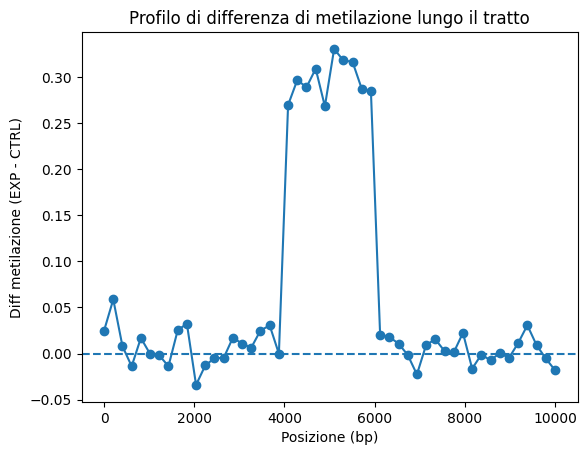

In [4]:
plt.plot(res_df["position"], res_df["diff_exp_minus_ctrl"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Posizione (bp)")
plt.ylabel("Diff metilazione (EXP - CTRL)")
plt.title("Profilo di differenza di metilazione lungo il tratto")
plt.show()

Si vede chiaramente una regione centrale con differenza positiva (~ipermetilata negli esposti).

## Identificare una DMR in modo semplice

Definiamo una "DMR" toy come una sequenza di CpG adiacenti in cui:
- la differenza media è ≥ 0.2
- i p-value sono ≤ 0.01
- le CpG sono contigue in posizione.

In [5]:
threshold_diff = 0.2
threshold_p = 0.01

candidate = res_df[(res_df["diff_exp_minus_ctrl"].abs() >= threshold_diff) & (res_df["pval"] <= threshold_p)].copy()
candidate = candidate.sort_values("position")
candidate

,position,mean_ctrl,mean_exp,diff_exp_minus_ctrl,pval
CpG,,,,,
cgDMR_21,4081,0.416349,0.686337,0.269988,2.595154e-15
cgDMR_22,4285,0.388959,0.686114,0.297155,2.117827e-14
cgDMR_23,4489,0.409073,0.698332,0.289259,2.614682e-15
cgDMR_24,4693,0.401853,0.711265,0.309412,7.321238e-17
cgDMR_25,4897,0.415654,0.684246,0.268592,2.193987e-12
cgDMR_26,5102,0.376878,0.707809,0.330932,8.866111e-14
cgDMR_27,5306,0.379044,0.697464,0.318421,1.917062e-17
cgDMR_28,5510,0.396276,0.713232,0.316956,1.136326e-17
cgDMR_29,5714,0.397161,0.684799,0.287639,2.618459e-15


Cerchiamo ora blocchi contigui di CpG candidate (in base alla posizione).

In [6]:
regions = []
if not candidate.empty:
    current_start = candidate["position"].iloc[0]
    current_end = candidate["position"].iloc[0]
    current_cpgs = [candidate.index[0]]
    current_diffs = [candidate["diff_exp_minus_ctrl"].iloc[0]]

    for cpg, row in candidate.iloc[1:].iterrows():
        pos = row["position"]
        diff = row["diff_exp_minus_ctrl"]
        # se la distanza è <= 300 bp, consideriamola contigua (soglia arbitraria)
        if pos - current_end <= 300:
            current_end = pos
            current_cpgs.append(cpg)
            current_diffs.append(diff)
        else:
            regions.append({
                "start": current_start,
                "end": current_end,
                "n_cpg": len(current_cpgs),
                "mean_diff": np.mean(current_diffs),
                "CpGs": current_cpgs,
            })
            current_start = pos
            current_end = pos
            current_cpgs = [cpg]
            current_diffs = [diff]

    # aggiungi l'ultima regione
    regions.append({
        "start": current_start,
        "end": current_end,
        "n_cpg": len(current_cpgs),
        "mean_diff": np.mean(current_diffs),
        "CpGs": current_cpgs,
    })

regions_df = pd.DataFrame(regions)
regions_df

,start,end,n_cpg,mean_diff,CpGs
0,4081,5918.0,10,0.297317,"[cgDMR_21, cgDMR_22, cgDMR_23, cgDMR_24, cgDMR..."


Queste sono le nostre **DMR toy**.

## Visualizzare la regione DMR sul profilo di differenza

Evidenziamo la prima regione (se esiste) sopra il profilo di differenza.

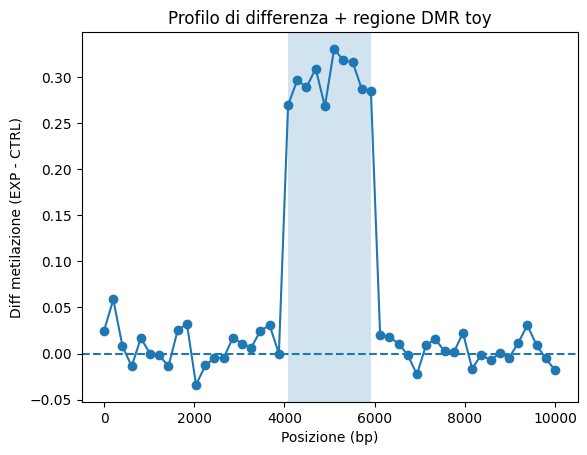

In [7]:
plt.plot(res_df["position"], res_df["diff_exp_minus_ctrl"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Posizione (bp)")
plt.ylabel("Diff metilazione (EXP - CTRL)")
plt.title("Profilo di differenza + regione DMR toy")

if not regions_df.empty:
    r0 = regions_df.iloc[0]
    plt.axvspan(r0["start"], r0["end"], alpha=0.2)

plt.show()

In analisi reali, i metodi per la ricerca di **DMR** (es. `methylKit`, `DSS`, `DMRcaller`) usano modelli statistici avanzati e considerano la correlazione tra CpG vicine.

Qui abbiamo costruito un semplice esempio per collegare:
- CpG singole (DMC)
- regioni di CpG con differenza coerente (DMR)

adatto per discussioni in aula su come l'ambiente possa rimodellare intere regioni regolatorie.